# Image Captioning with Transformers
### CNN Image Features Encoder - Transformer Caption Decoder Architecture

## Setting Up

### 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange
import tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset,  DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical
from pycocotools.coco import COCO
from PIL import Image

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

# HugginFace's transformers library 
from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# For calculating Bleu score
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.tokenize import word_tokenize
import json
import time

torch.backends.cuda.matmul.allow_tf32 = True

### 2. Configure Parameters and Access Dataset

In [9]:
# Configuration parameters
learning_rate = 1e-4
image_size = 224
nepochs = 30
batch_size = 32
hidden_size = 512
num_decoder_layers = 6
num_heads = 8

# Define base paths
BASE_PATH = 'data'
IMG_DIR = os.path.join(BASE_PATH, 'images')
ANN_DIR = os.path.join(BASE_PATH, 'annotations/trainval2017')

train_image_path = os.path.join(IMG_DIR, 'train2017')
train_ann_file = os.path.join(ANN_DIR, 'captions_train2017.json')

val_image_path = os.path.join(IMG_DIR, 'val2017')
val_ann_file = os.path.join(ANN_DIR, 'captions_val2017.json')

print(f"Train Image path: {train_image_path}")
print(f"Train annotation path: {train_ann_file}")
print(f"Val Image path: {val_image_path}")
print(f"Val annotation path: {val_ann_file}")

Train Image path: data\images\train2017
Train annotation path: data\annotations/trainval2017\captions_train2017.json
Val Image path: data\images\val2017
Val annotation path: data\annotations/trainval2017\captions_val2017.json


## Datasets

### 1. CocoDataset Class

In [10]:
class CocoDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images
            ann_file (string): Path to annotation file
            transform: Transform pipeline for images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']

        # Load and transform image
        image = Image.open(os.path.join(self.root_dir, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, caption, img_id

### 2. Data Loading and Processing

In [11]:
train_transform = transforms.Compose([transforms.Resize((256, 256)),  # Larger size for random cropping
                                      transforms.RandomCrop((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)]) 

transform = transforms.Compose([transforms.Resize((224, 224)),  # No random cropping during validation
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

# Create datasets
train_dataset = CocoDataset(
    root_dir=train_image_path,
    ann_file=train_ann_file,
    transform=train_transform,
) 

val_dataset = CocoDataset(
    root_dir=val_image_path,
    ann_file=val_ann_file,
    transform=transform,
)

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


### 3. Visualize Data

In [12]:
# Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
test_images, test_captions, test_img_ids = dataiter

A couple of zebra eating a small pile of hay.


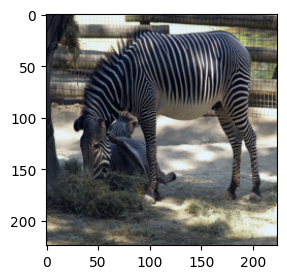

In [13]:
# Lets visualise a snippet of a batch of images and captions
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[0]
print(caption)

In [14]:
# Visualize the captions in a batch
print(test_captions)

('A couple of zebra eating a small pile of hay.', 'A group of people standing on top of a dirt field.', 'Two zebras grazing from grass next to a tree.', 'The man is sitting next to his bed on the laptop. ', 'a pregnant zebra eating grass close to two elephants ', 'Two snowboarders riding down a hill in a snowy forest.', 'A white horse and a white llama in a grassy field. ', 'A picture of a young boy laying on top of a bed.', 'A cow grazing on the grass on the side of a side walk.', 'Airplane parked at an airport in the city.', 'a blue and yellow fire hydrant sitting on the sidewalk next to a quiet street', 'A couple of guys are playing ball on a side walk.', 'a group of people listening to music or possible playing video games', 'A young redheaded woman in sunglasses and black tank top holds a black leather purse and a white umbrella.', 'A container holds apples, a banana, snap peas and triangle finger foods.', 'And antique red car is positioned in front of an airplane. ', 'A coin layi

Visualizing all images in the batch:


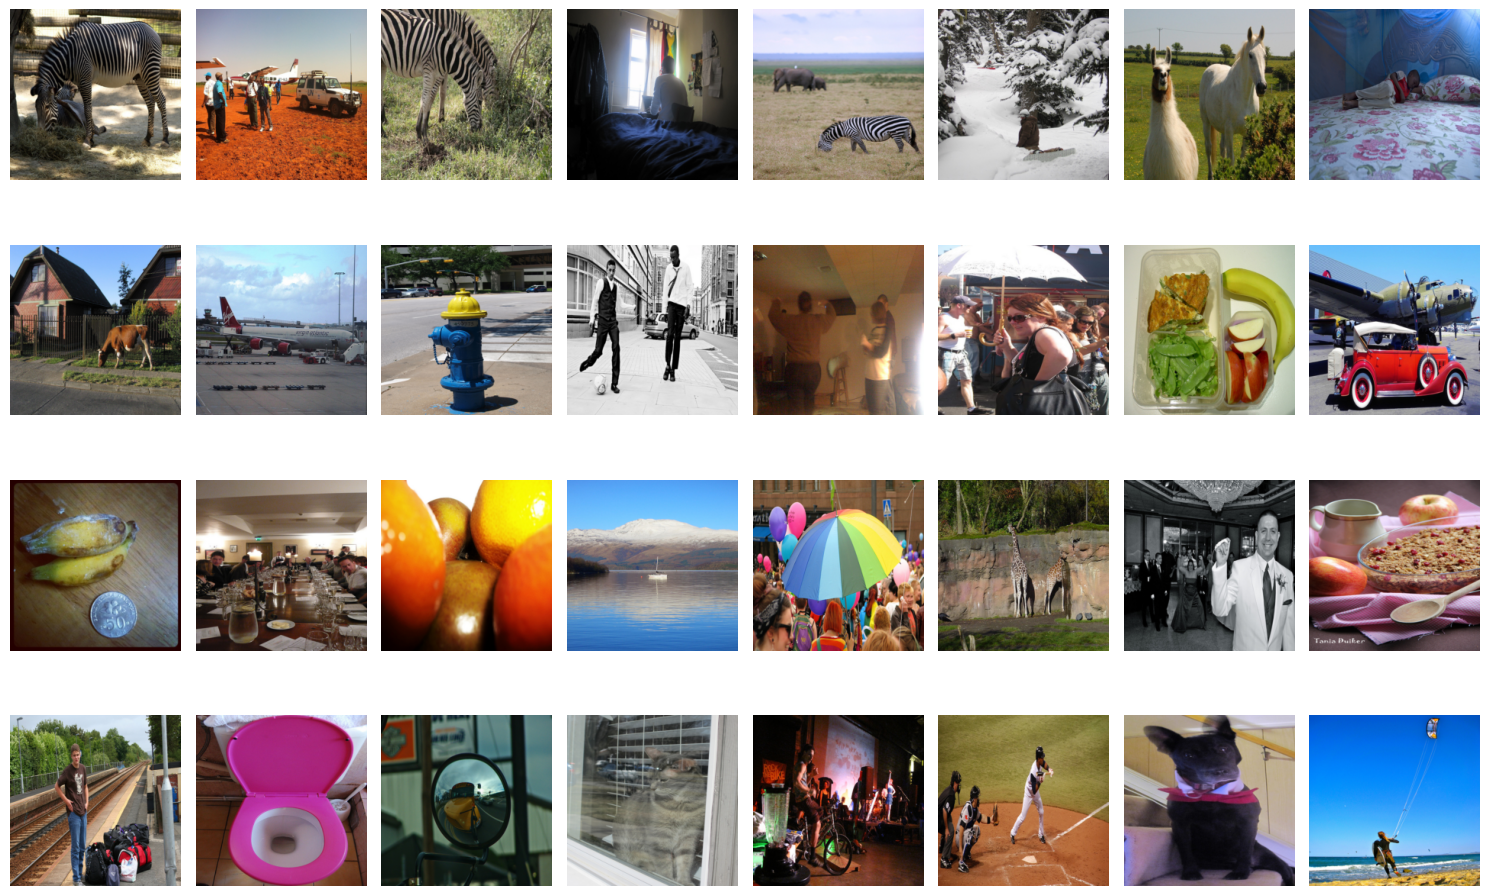

In [15]:
# Unnormalize the images for visualization
def unnormalize_image(img):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    img = img * std + mean  # Unnormalize
    img = img.cpu().numpy()  # Convert to a NumPy array for visualization
    img = img.clip(0, 1)  # Clip to valid range
    return img

# Visualize the images in the batch
print("Visualizing all images in the batch:")
plt.figure(figsize=(15, 10))
for i in range(len(test_images)):
    plt.subplot(4, 8, i + 1)  # Adjust the grid size if needed
    plt.imshow(unnormalize_image(test_images[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [16]:
# Visualize it in tensor form
print(test_images)

tensor([[[[-1.3815, -1.5014, -1.4500,  ...,  1.2557,  2.0263,  1.8893],
          [-1.3644, -1.4843, -1.4329,  ...,  0.8618,  1.4612,  1.4783],
          [-1.3644, -1.4843, -1.3987,  ..., -0.0458, -0.2171,  0.3309],
          ...,
          [ 1.0159,  0.9132,  0.7591,  ...,  0.1939,  0.0912,  0.0398],
          [ 1.1872,  1.3070,  1.2728,  ...,  0.1254,  0.1597,  0.0912],
          [ 1.3242,  1.4954,  1.3755,  ...,  0.0569,  0.1254,  0.0741]],

         [[-1.2829, -1.4405, -1.3704,  ...,  1.0980,  1.9734,  1.7983],
          [-1.3004, -1.4580, -1.3354,  ...,  0.5203,  1.1681,  1.2381],
          [-1.3354, -1.4055, -1.3529,  ..., -0.2150, -0.3375,  0.1352],
          ...,
          [ 0.6604,  0.6254,  0.4678,  ...,  0.2052,  0.0476,  0.0651],
          [ 0.9055,  1.0455,  1.0280,  ...,  0.1176,  0.1527,  0.1001],
          [ 1.0980,  1.2381,  1.0805,  ...,  0.0651,  0.1527,  0.0826]],

         [[-1.1073, -1.2641, -1.1944,  ...,  0.3568,  1.3502,  1.0888],
          [-1.1247, -1.1770, -

## Tokenize
We will be using pre-built Tokenizer for the BERT Model built for Transformers

In [17]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

c:\Users\Jordan\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
tokenizer.vocab_size

30522

In [19]:
# Let's test with one caption
sample_caption = test_captions[0]
print("\nSample caption:", sample_caption)
# Ensure  `test_captions` is a list of strings
test_captions_list = [caption for caption in test_captions]


Sample caption: A couple of zebra eating a small pile of hay.


In [20]:
tokens = tokenizer(test_captions_list, padding=True, truncation=True, return_tensors="pt")

# Batch size x sequence length
print(tokens['input_ids'])
print(len(tokens['input_ids']))

# Sequence length
print(tokens['input_ids'][0])
print(len(tokens['input_ids'][0]))

# print the length of all the captions in a batch
for i in range(len(tokens['input_ids'])):
    print(len(tokens['input_ids'][i]), end=', ')

tensor([[  101,  1037,  3232,  1997, 29145,  5983,  1037,  2235,  8632,  1997,
         10974,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1037,  2177,  1997,  2111,  3061,  2006,  2327,  1997,  1037,
          6900,  2492,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  2048, 29145,  2015, 15400,  2013,  5568,  2279,  2000,  1037,
          3392,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1996,  2158,  2003,  3564,  2279,  2000,  2010,  2793,  2006,
          1996, 12191,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1037,  6875, 29145,  5983,  5568,  2485,  2000,  2048, 16825,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  2048,  4586,  6277,  2545,  5559,  209

In [21]:
print(tokenizer.decode(tokens['input_ids'][0]))

[CLS] a couple of zebra eating a small pile of hay. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


Displaying 3 random samples from the dataset...

Sample 1:
--------------------------------------------------------------------------------


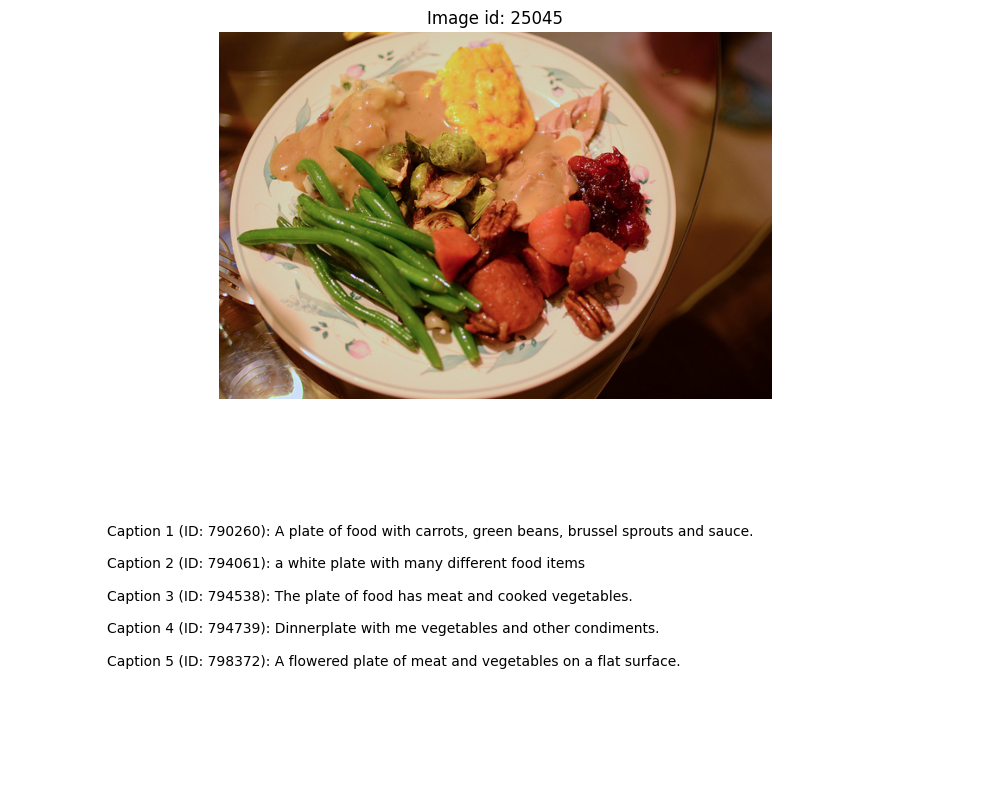


Sample 2:
--------------------------------------------------------------------------------


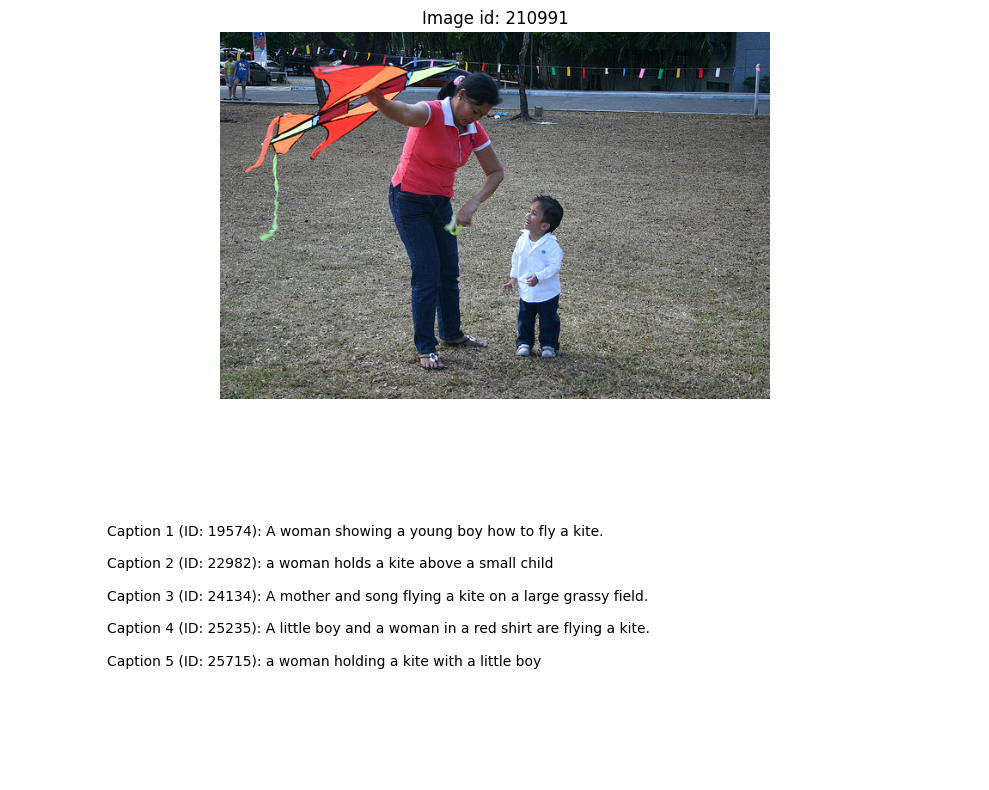


Sample 3:
--------------------------------------------------------------------------------


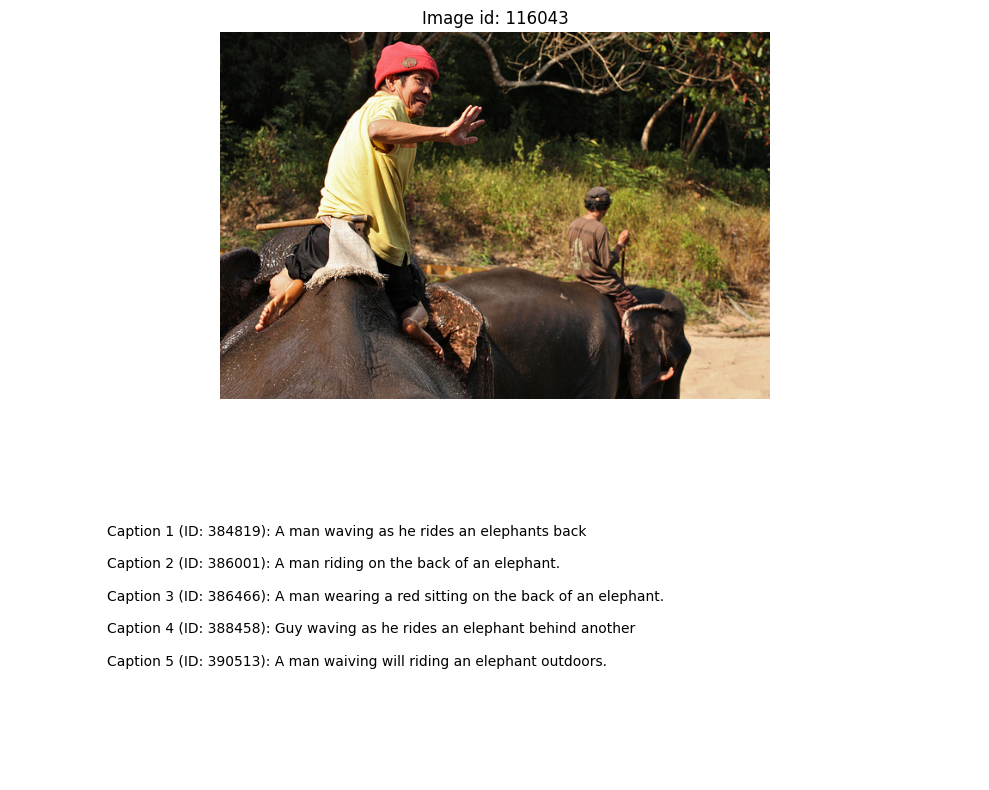

In [22]:
def display_dataset_samples(dataset, num_samples=3):
    """
    Display multiple random samples from the dataset with their captions.

    Args:
        dataset: CocoDataset instance
        num_samples: Number of samples to display
    """
    coco_caps = dataset.coco
    root_dir = dataset.root_dir

    print(f"Displaying {num_samples} random samples from the dataset...")

    for i in range(num_samples):
        print(f"\nSample {i+1}:")
        print("-" * 80)

        # Get a random image ID
        img_ids = coco_caps.getImgIds()
        img_id = random.choice(img_ids)

        # Load image info
        img_info = coco_caps.loadImgs([img_id])[0]

        # Load image using PIL
        img_path = os.path.join(root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get and display captions
        ann_ids = coco_caps.getAnnIds(imgIds=img_id)
        anns = coco_caps.loadAnns(ann_ids)

        # Create text display for captions
        caption_text = '\n\n'.join([f"Caption {i+1} (ID: {ann['id']}): {ann['caption']}"
                                   for i, ann in enumerate(anns)])

        # Display image and captions
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Image id: ' + str(img_id))
        ax2.text(0.1, 0.5, caption_text,
                 wrap=True,
                 verticalalignment='center',
                 fontsize=10)
        ax2.axis('off')
        plt.tight_layout()
        plt.show()

# Display some samples from the training dataset
display_dataset_samples(train_dataset, num_samples=3)

In [23]:
class TokenDrop(nn.Module):
    """
    For a batch of tokens indices, randomly replace a non-specical token.
    
    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop
        
        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()
        
        replace_with = (self.blank_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

## Create Encoder-Decoder Network

In [24]:
# CNN Encoder
class CNNEncoder(nn.Module):
    def __init__(self, hidden_size=512):
        super(CNNEncoder, self).__init__()
        resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.conv_reduce = nn.Conv2d(2048, hidden_size, kernel_size=1)
        
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def forward(self, images):
        features = self.resnet(images)
        features = self.conv_reduce(features)
        batch_size, hidden_size, h, w = features.shape
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch_size, -1, hidden_size)
        return features

In [25]:
# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    

# Define a module for attention blocks
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # Perform multi-head attention operation
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, 
                                   key_padding_mask=key_mask)[0]


# Define a module for a transformer block with self-attention 
# and optional causal masking
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder

        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, 
                                    masking=masking)
        
        # Layer normalization for the output of the first attention layer
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                                        num_heads=num_heads, masking=False)
        
        # Layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # Perform self-attention operation
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        # If decoder, perform additional cross-attention layer
        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        # Apply MLP and layer normalization
        x = self.mlp(x) + x
        return self.norm_mlp(x)

    
# Define a decoder module for the Transformer architecture
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=True) for _ in range(num_layers)
        ])
                
        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs, 
                           input_key_mask=input_padding_mask, 
                           cross_key_mask=encoder_padding_mask, 
                           kv_cross=encoder_output)
        
        return self.fc_out(embs)

In [26]:
# Define an Image Captioning Encoder-Decoder module with the Transformer architecture
class TransformerImageCaptioningModel(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, 
                 hidden_size=128, num_layers=6, num_heads=4):
        super(TransformerImageCaptioningModel, self).__init__()
        
        # Create an encoder and decoder with specified parameters
        # self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, 
        #                              patch_size=patch_size, hidden_size=hidden_size, 
        #                              num_layers=num_layers[0], num_heads=num_heads)
        self.encoder = CNNEncoder(hidden_size=hidden_size)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers, num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = padding_mask == 0

        # Encode the input sequence
        encoded_seq = self.encoder(images=input_image)
        
        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

## Initialise Model and Optimizer

In [27]:
# Set the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model
caption_model = TransformerImageCaptioningModel(image_size=image_size, channels_in=test_images.shape[1], 
                                     num_emb=tokenizer.vocab_size, 
                                     num_layers=num_decoder_layers,hidden_size=hidden_size, 
                                     num_heads=num_heads).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

# Initialize the training loss logger
training_loss_logger = []

C:\Users\Jordan\AppData\Local\Temp\ipykernel_4828\1063137238.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [28]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 81066362 (Approximately 81 Million) Parameters!


## Training

In [29]:
def generate_caption(model, image, tokenizer, device, max_length=50, temperature=0.5):
    """Generate a caption for a single image using the provided model"""
    model.eval()
    
    # Add the Start-Of-Sentence token
    sos_token = 101 * torch.ones(1, 1).long()
    log_tokens = [sos_token]
    
    with torch.no_grad():
        # Encode the input image
        with torch.cuda.amp.autocast(enabled=False):
            image_embedding = model.encoder(image.unsqueeze(0).to(device))
        
        # Generate the caption tokens
        for _ in range(max_length):
            input_tokens = torch.cat(log_tokens, 1)
            
            # Decode the input tokens
            data_pred = model.decoder(input_tokens.to(device), image_embedding)
            
            # Sample from the distribution
            dist = Categorical(logits=data_pred[:, -1] / temperature)
            next_tokens = dist.sample().reshape(1, 1)
            
            # Append the next token
            log_tokens.append(next_tokens.cpu())
            
            # Break if End-Of-Caption token is predicted
            if next_tokens.item() == 102:
                break
    
    # Convert token list to tensor
    pred_text = torch.cat(log_tokens, 1)
    return pred_text[0]

In [30]:
def calculate_bleu_scores(model, data_loader, tokenizer, device, max_length=50, temperature=0.5):
    """Calculate BLEU scores for the model predictions using all available reference captions"""
    model.eval()
    references_dict = {}
    hypotheses_dict = {}
    
    with torch.no_grad():
        bleu_progress_bar = tqdm.tqdm(data_loader, desc='Calculating BLEU scores')
        for images, _, img_ids in bleu_progress_bar:
            images = images.to(device)
            
            # Generate captions for batch
            for i, img in enumerate(images):
                img_id = img_ids[i].item()
                
                # Generate caption for the image
                output_ids = generate_caption(model, img, tokenizer, device, max_length, temperature)
                predicted_caption = tokenizer.decode(output_ids, skip_special_tokens=True)
                
                # Get all reference captions for this image from COCO
                ann_ids = data_loader.dataset.coco.getAnnIds(imgIds=img_id)
                anns = data_loader.dataset.coco.loadAnns(ann_ids)
                reference_captions = [ann['caption'].lower() for ann in anns]
                
                # Process reference captions
                references = [word_tokenize(ref_cap) for ref_cap in reference_captions]
                hypothesis = word_tokenize(predicted_caption.lower())
                
                # Store using image_id as key
                references_dict[img_id] = references
                hypotheses_dict[img_id] = hypothesis
    
    # Calculate BLEU scores for different n-grams
    bleu_scores = {}
    weights = {
        'bleu-1': (1.0, 0, 0, 0),
        'bleu-2': (0.5, 0.5, 0, 0),
        'bleu-3': (0.33, 0.33, 0.33, 0),
        'bleu-4': (0.25, 0.25, 0.25, 0.25)
    }
    
    # Convert to format expected by corpus_bleu
    references = [references_dict[img_id] for img_id in hypotheses_dict.keys()]
    hypotheses = [hypotheses_dict[img_id] for img_id in hypotheses_dict.keys()]
    
    # Calculate corpus-level BLEU scores
    for metric, weight in weights.items():
        score = corpus_bleu(references, hypotheses, weights=weight)
        bleu_scores[metric] = score
    
    return bleu_scores

# Helper function to evaluate model with all metrics
def evaluate_model(model, data_loader, tokenizer, device):
    """Evaluate model using BLEU scores and additional metrics"""
    print("Calculating evaluation scores...")
    
    # Calculate BLEU scores
    bleu_scores = calculate_bleu_scores(
        model=model,
        data_loader=data_loader,
        tokenizer=tokenizer,
        device=device,
        temperature=0.5
    )
    
    # Print scores
    print("\nEvaluation Results:")
    print("-" * 50)
    for metric, score in bleu_scores.items():
        print(f"{metric.upper():<10}: {score:.4f}")
    
    return bleu_scores

In [31]:
# Load best weights
checkpoint_path = 'data/best_model.pt'  # Adjust path as needed
checkpoint = torch.load(checkpoint_path, map_location=device)
    
# Load model weights
caption_model.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Check val loss
print(checkpoint['val_losses'])

C:\Users\Jordan\AppData\Local\Temp\ipykernel_4828\89136572.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


[1.9247959458919437, 1.8502256583679668, 1.8072132003276855, 1.7904186980498722, 1.7738121403452685, 1.7579592341352301, 1.754264655930307, 1.7287803708439897, 1.7355220238570972, 1.7260779651534526, 1.723815761868606, 1.7218676320732098, 1.7107720338475063, 1.7147756903372762, 1.7099403322810103, 1.7072972446451407, 1.7140826056985294, 1.7174843400335678, 1.7024144321451407]


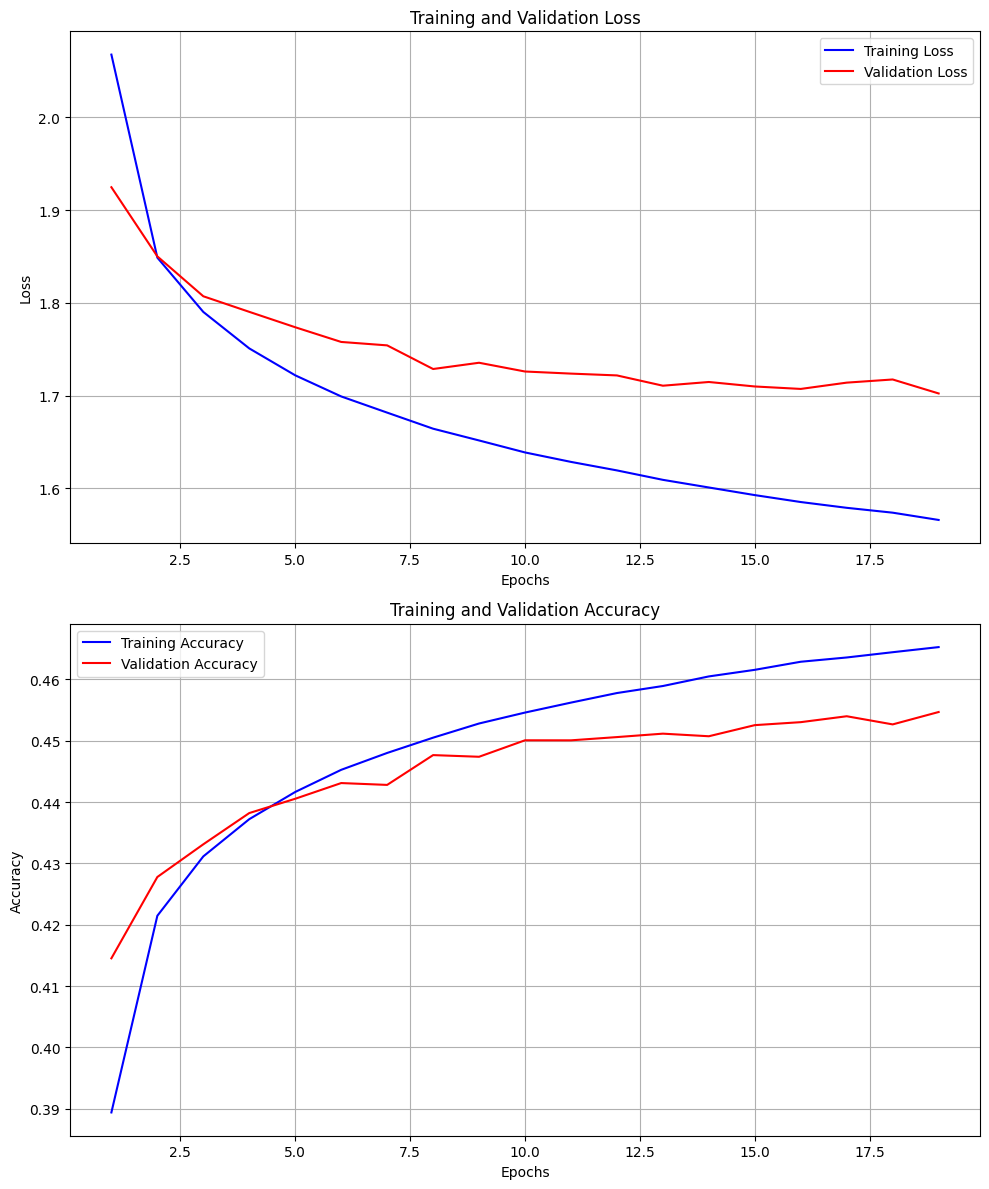

Final Training Loss: 1.5660
Final Validation Loss: 1.7024
Final Training Accuracy: 0.4653
Final Validation Accuracy: 0.4547


In [ ]:
# Extract metrics
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot losses
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print final metrics
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

In [35]:
from torchinfo import summary
# Concise summary
summary(caption_model, 
        input_data=[
            torch.zeros(1, 3, 224, 224).to(device),  # image
            torch.zeros(1, 50, dtype=torch.long).to(device),  # target_seq
            torch.ones(1, 50, dtype=torch.long).to(device)  # padding_mask
        ],
        depth=2,  # Reduce depth to show less nested layers
        verbose=0,  # Reduce verbosity
        col_names=["output_size", "num_params"],  # Show only essential columns
        row_settings=["var_names"])

Layer (type (var_name))                                                Output Shape              Param #
TransformerImageCaptioningModel (TransformerImageCaptioningModel)      [1, 50, 30522]            --
├─CNNEncoder (encoder)                                                 [1, 49, 512]              --
│    └─Sequential (resnet)                                             [1, 2048, 7, 7]           (23,508,032)
│    └─Conv2d (conv_reduce)                                            [1, 512, 7, 7]            1,049,088
├─Decoder (decoder)                                                    [1, 50, 30522]            --
│    └─Embedding (embedding)                                           [1, 50, 512]              15,627,264
│    └─SinusoidalPosEmb (pos_emb)                                      [50, 512]                 --
│    └─ModuleList (blocks)                                             --                        25,224,192
│    └─Linear (fc_out)                                        

In [40]:
# Create sample inputs for summary
batch_size = 1
channels = 3
image_height = 224
image_width = 224
seq_length = 50  # typical sequence length for captions

# Generate sample inputs
sample_image = torch.zeros(batch_size, channels, image_height, image_width)
sample_captions = torch.zeros(batch_size, seq_length, dtype=torch.long)
sample_padding_mask = torch.ones(batch_size, seq_length, dtype=torch.long)  # Added padding mask

# Model Summary
summary(caption_model, 
        input_data=[
            sample_image.to(device), 
            sample_captions.to(device),
            sample_padding_mask.to(device)  # Added padding mask
        ],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=5)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
TransformerImageCaptioningModel (TransformerImageCaptioningModel)      [1, 3, 224, 224]     [1, 50, 30522]       --                   Partial
├─CNNEncoder (encoder)                                                 --                   [1, 49, 512]         --                   Partial
│    └─Sequential (resnet)                                             [1, 3, 224, 224]     [1, 2048, 7, 7]      --                   False
│    │    └─Conv2d (0)                                                 [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    │    └─BatchNorm2d (1)                                            [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    │    └─ReLU (2)                                                   [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    │    └─Max

In [27]:
bleu_scores = calculate_bleu_scores(
                model=caption_model,
                data_loader=data_loader_val,
                tokenizer=tokenizer,
                device=device,
                temperature=0.5
            )
# Print the scores
print("\nEvaluation Results:")
print("-" * 50)
for metric, score in bleu_scores.items():
    print(f"{metric.upper():<10}: {score:.4f}")

Calculating BLEU scores:   0%|                                                                 | 0/782 [00:00<?, ?it/s]C:\Users\Irfaan\AppData\Local\Temp\ipykernel_26440\1291174270.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Calculating BLEU scores: 100%|███████████████████████████████████████████████████████| 782/782 [43:48<00:00,  3.36s/it]



Evaluation Results:
--------------------------------------------------
BLEU-1    : 0.6919
BLEU-2    : 0.4888
BLEU-3    : 0.3450
BLEU-4    : 0.2384


In [32]:
# Load best weights
checkpoint_path = 'model_checkpoints/best_model.pth'  # Adjust path as needed
checkpoint = torch.load(checkpoint_path, map_location=device)
    
# Load model weights
caption_model.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Check val loss
print(checkpoint['val_losses'])

C:\Users\Irfaan\AppData\Local\Temp\ipykernel_26440\797857797.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

[1.9247959458919437, 1.8502256583679668, 1.8072132003276855, 1.7904186980498722, 1.7738121403452685, 1.7579592341352301, 1.754264655930307, 1.7287803708439897, 1.7355220238570972, 1.7260779651534526, 1.723815761868606, 1.7218676320732098, 1.7107720338475063, 1.7147756903372762, 1.7099403322810103, 1.7072972446451407, 1.7140826056985294, 1.7174843400335678, 1.7024144321451407]


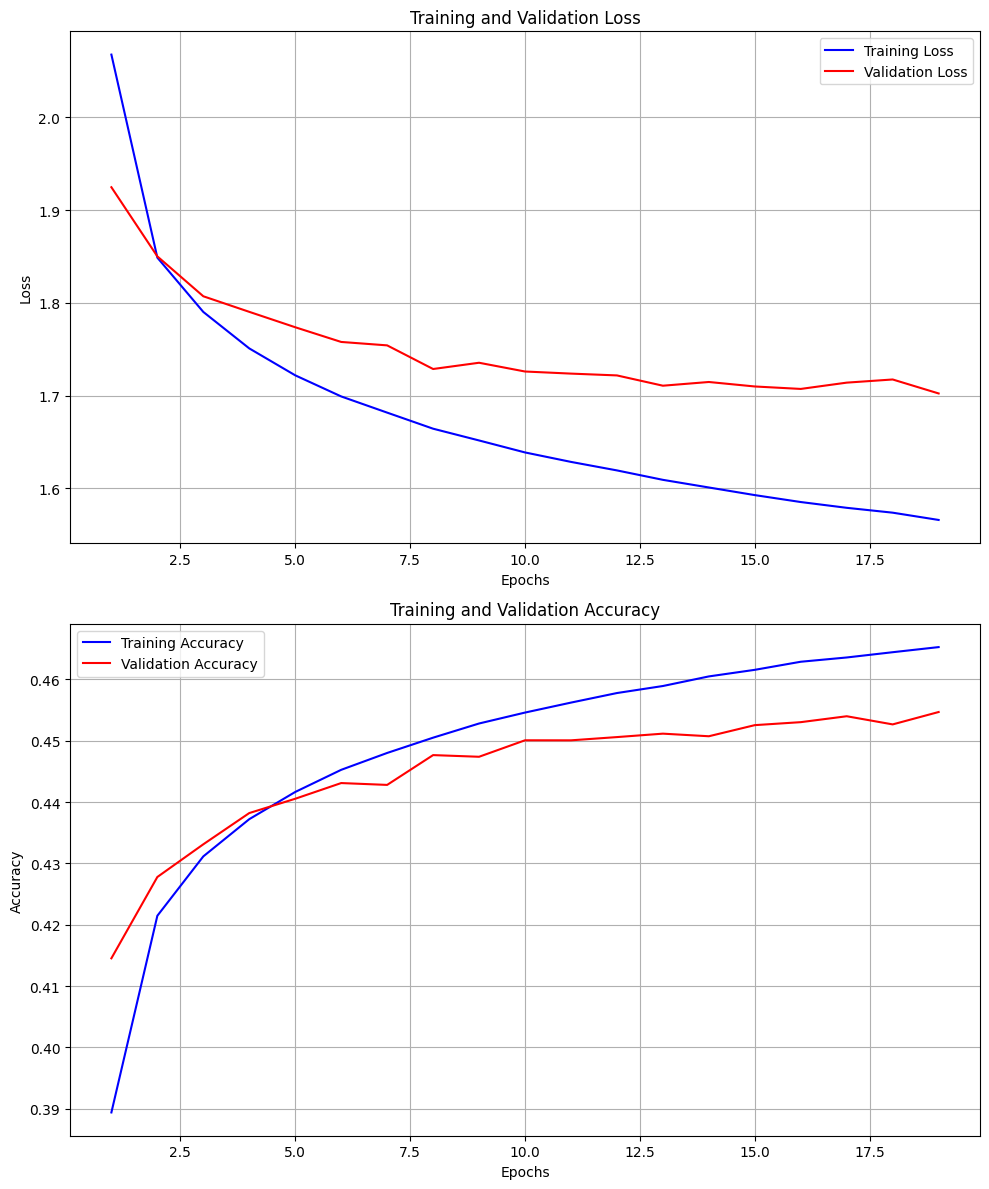

Final Training Loss: 1.5660
Final Validation Loss: 1.7024
Final Training Accuracy: 0.4653
Final Validation Accuracy: 0.4547


In [33]:
# Extract metrics
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot losses
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print final metrics
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

In [35]:
print(f"Best Epoch is: {checkpoint['epoch']}")

Best Epoch is: 19


In [29]:
bleu_scores = calculate_bleu_scores(
                model=caption_model,
                data_loader=data_loader_val,
                tokenizer=tokenizer,
                device=device,
                temperature=0.5
            )
# Print the scores
print("\nEvaluation Results:")
print("-" * 50)
for metric, score in bleu_scores.items():
    print(f"{metric.upper():<10}: {score:.4f}")

Calculating BLEU scores:   0%|                                                                 | 0/782 [00:00<?, ?it/s]C:\Users\Irfaan\AppData\Local\Temp\ipykernel_26440\1291174270.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Calculating BLEU scores: 100%|███████████████████████████████████████████████████████| 782/782 [47:58<00:00,  3.68s/it]



Evaluation Results:
--------------------------------------------------
BLEU-1    : 0.6906
BLEU-2    : 0.4873
BLEU-3    : 0.3431
BLEU-4    : 0.2369
